In [1]:
# from gidnet.qubitreuse import GidNET

# from qiskit import QuantumCircuit
# circ = QuantumCircuit(5)

# circ.cx(1,2)
# circ.cx(0,3)

# circ.cx(1,4)
# circ.cx(2,4)
# circ.cx(3,4)


# circ.measure_all()

# circ.draw('mpl')


# gidnet = GidNET(circ)
# dynamic_circ = gidnet.compile_to_dynamic_circuit(iterations=20, draw=True)

# gidnet.dynamic_circuit_width # check the width of the compiled dynamic circuit

In [60]:
from gidnet.qubitreuse import GidNET

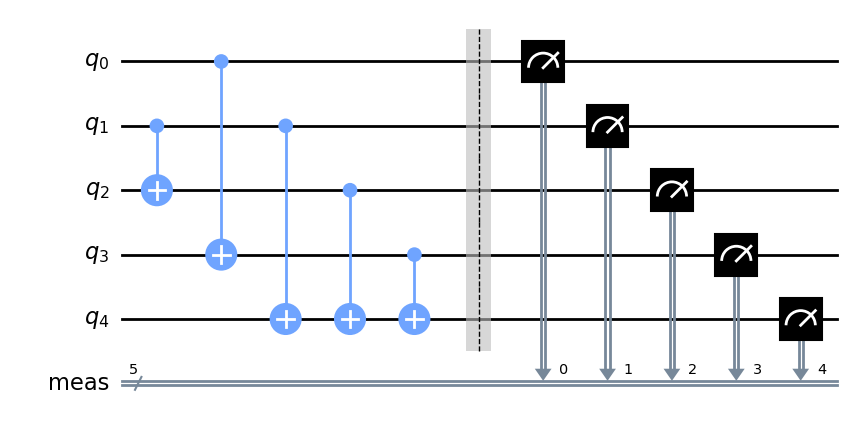

In [62]:
from qiskit import QuantumCircuit
circ = QuantumCircuit(5)

circ.cx(1,2)
circ.cx(0,3)

circ.cx(1,4)
circ.cx(2,4)
circ.cx(3,4)


circ.measure_all()

circ.draw('mpl')

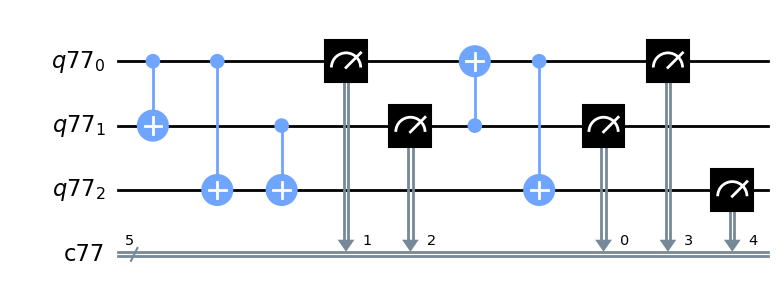

In [66]:
gidnet = GidNET(circ)
gidnet.compile_to_dynamic_circuit(draw=True)

In [ ]:
[[1, 0], [2, 3], [4]]
[[1, 3], [2, 0], [4]]

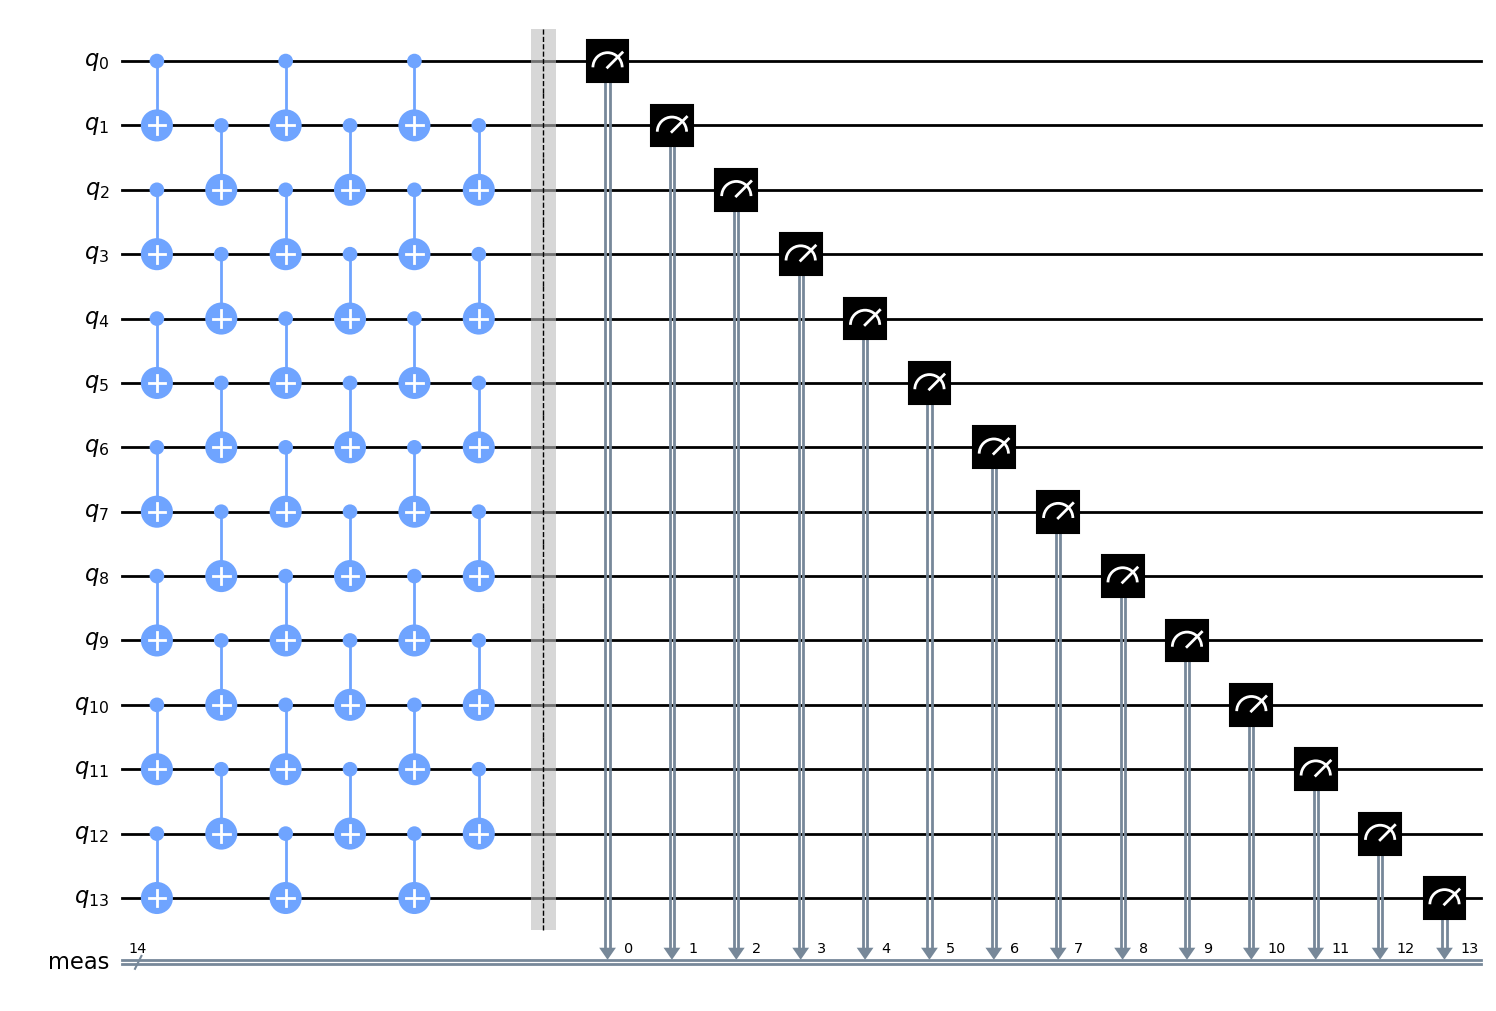

In [4]:
num_qubits = 14
k = 3
brick_circ = QuantumCircuit(num_qubits)

for i in range(k):
    for q in range(int(num_qubits/2)):
        brick_circ.cx(2*q, 2*q+1)
        
    for q in range(int(num_qubits/2)-1):
        brick_circ.cx(2*q+1, 2*q+2)
        
    # circ.barrier()

brick_circ.measure_all()

brick_circ.draw('mpl', fold=1)


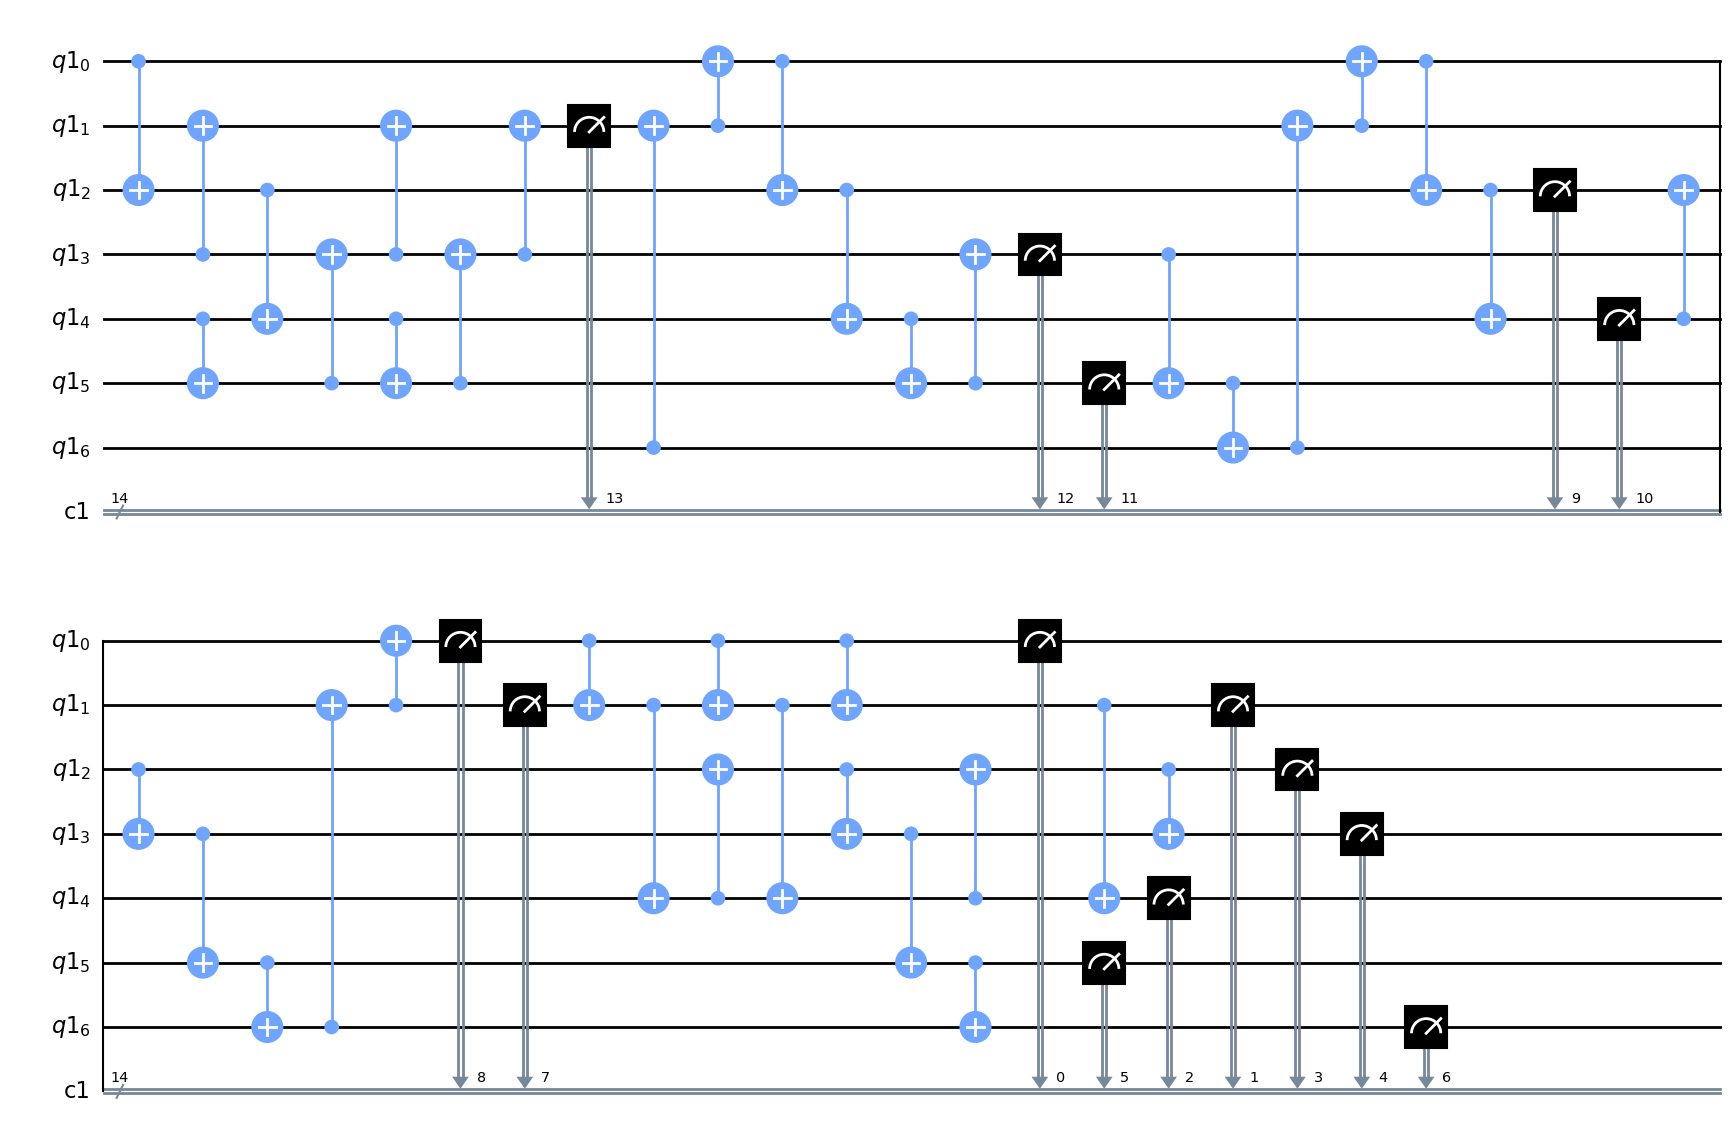

In [5]:
gidnet = GidNET(brick_circ)
gidnet.compile_to_dynamic_circuit(iterations=20, draw=True)

In [6]:
gidnet.dynamic_circuit_width

7

In [27]:
import pytest
import numpy as np
from qiskit import QuantumCircuit
from gidnet.qubitreuse import GidNET

@pytest.fixture
def simple_circuit():
    """Creates a simple quantum circuit with 3 qubits."""
    qc = QuantumCircuit(3)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.measure_all()
    return qc

@pytest.fixture
def complex_circuit():
    """Creates a more complex quantum circuit with 5 qubits."""
    qc = QuantumCircuit(5)
    qc.cx(1, 2)
    qc.cx(0, 3)
    qc.cx(1, 4)
    qc.cx(2, 4)
    qc.cx(3, 4)
    qc.measure_all()
    return qc

@pytest.fixture
def gidnet_simple(simple_circuit):
    """Fixture for initializing GidNET with a simple circuit."""
    # qc = simple_circuit()
    return GidNET(simple_circuit)

@pytest.fixture
def gidnet_complex(complex_circuit):
    """Fixture for initializing GidNET with a complex circuit."""
    # qc = complex_circuit()
    return GidNET(complex_circuit)

def test_initialization(gidnet_simple):
    """Test if the GidNET instance initializes correctly."""
    assert gidnet_simple.circuit is not None
    assert gidnet_simple.dynamic_circuit is None
    assert gidnet_simple.qubit_reuse_sequences is None


def test_compute_initial_biadjacency_and_candidate_matrix(gidnet_simple, gidnet_complex):
    """Test if biadjacency and candidate matrices are generated properly."""
    intial_biadjacency_matrix, intial_candidate_matrix = gidnet_simple.compute_intial_biadjacency_and_candidate_matrix()
    assert isinstance(intial_biadjacency_matrix, np.ndarray)
    assert isinstance(intial_candidate_matrix, np.ndarray)
    simple_biadjacency_mat = np.array([[1, 1, 1], 
                                       [1, 1, 1], 
                                       [0, 1, 1]])
    simple_candidate_mat = (np.ones((3, 3), dtype=int) - np.array([[1, 1, 1], 
                                                                   [1, 1, 1], 
                                                                   [0, 1, 1]])).T
    assert np.allclose(intial_biadjacency_matrix, simple_biadjacency_mat)
    assert np.allclose(intial_candidate_matrix, simple_candidate_mat)

    # test for complex circuit
    intial_biadjacency_matrix, intial_candidate_matrix = gidnet_complex.compute_intial_biadjacency_and_candidate_matrix()
    assert isinstance(intial_biadjacency_matrix, np.ndarray)
    assert isinstance(intial_candidate_matrix, np.ndarray)
    complex_biadjacency_mat = np.array([[1, 0, 0, 1, 1], 
                                        [0, 1, 1, 1, 1], 
                                        [0, 1, 1, 1, 1], 
                                        [1, 0, 0, 1, 1], 
                                        [0, 1, 1, 1, 1]])
    complex_candidate_mat = (np.ones((5, 5), dtype=int) - np.array([[1, 0, 0, 1, 1], 
                                                                    [0, 1, 1, 1, 1], 
                                                                    [0, 1, 1, 1, 1], 
                                                                    [1, 0, 0, 1, 1], 
                                                                    [0, 1, 1, 1, 1]])).T
    assert np.allclose(intial_biadjacency_matrix, complex_biadjacency_mat)
    assert np.allclose(intial_candidate_matrix, complex_candidate_mat)

@pytest.mark.parametrize("iterations", [10, 20])
def test_compile_to_dynamic_circuit(gidnet_simple, gidnet_complex, iterations):
    """Test if GidNET compiles a valid dynamic circuit."""
    dynamic_circ = gidnet_simple.compile_to_dynamic_circuit(iterations=iterations)
    assert isinstance(dynamic_circ, QuantumCircuit)
    assert dynamic_circ.num_qubits > 0  # Ensuring qubits exist
    assert sorted(gidnet_simple.qubit_reuse_sequences) == sorted([[0, 2], [1]]) # Ensuring correct reuse sequence is returned

    # test for complex circuit
    dynamic_circ = gidnet_complex.compile_to_dynamic_circuit(iterations=iterations)
    assert isinstance(dynamic_circ, QuantumCircuit)
    assert dynamic_circ.num_qubits > 0  # Ensuring qubits exist
    # assert (sorted(gidnet_complex.qubit_reuse_sequences) == sorted([[1, 0], [2, 3], [4]])) | (sorted(gidnet_complex.qubit_reuse_sequences) == sorted([[1, 3], [2, 0], [4]])) # Ensuring correct reuse sequence is returned
    
    
    # Define the set of expected qubit reuse sequences (order of outer list does not matter)
    expected_sequences = [
        [[1, 0], [2, 3], [4]],   # Expected valid output 1
        [[1, 3], [2, 0], [4]]    # Expected valid output 2
    ]
    
    # Check if the actual output matches any expected sequence
    assert any(sorted(gidnet_complex.qubit_reuse_sequences) == sorted(seq) for seq in expected_sequences)


@pytest.mark.parametrize("terminal", [1, 2, 3])
def test_best_reuse_sequence(gidnet_complex, terminal):
    """Test that best_reuse_sequence returns a valid sequence."""
    reuse_sequence = gidnet_complex.best_reuse_sequence(terminal)
    assert isinstance(reuse_sequence, list)
    assert terminal in reuse_sequence


@pytest.mark.parametrize("iterations", [10, 20])
def test_compute_optimized_reuse_sequences(gidnet_complex, iterations):
    """Test if optimized qubit reuse sequences are computed."""
    reuse_sequences = gidnet_complex.compute_optimized_reuse_sequences(iterations=iterations)
    assert isinstance(reuse_sequences, list)
    assert all(isinstance(seq, list) for seq in reuse_sequences)

# def test_add_qubit_reuse_edges(gidnet_complex):
#     """Test if qubit reuse edges are correctly added without cycles."""
#     gidnet_complex.add_qubit_reuse_edges()
#     assert hasattr(gidnet_complex, "circuit_dag_with_reuse_edges")
#     assert len(gidnet_complex.reuse_edges) >= 0  # Ensuring edges were added

@pytest.mark.parametrize("terminal", [1, 2, 3])
def test_best_reuse_sequence(gidnet_complex, terminal):
    """Test that best_reuse_sequence returns a valid sequence."""
    reuse_sequence = gidnet_complex.best_reuse_sequence(terminal)
    assert isinstance(reuse_sequence, list)
    assert terminal in reuse_sequence

def test_finalize_reuse(gidnet_complex):
    """Test if finalize_reuse correctly processes reuse sequences."""
    test_sequence = [[1, 0], [2, 3]]
    final_sequence = gidnet_complex.finalize_reuse(test_sequence)
    assert isinstance(final_sequence, list)
    assert len(final_sequence) >= len(test_sequence)
    assert sorted(final_sequence) == sorted([[0, 1], [2, 3], [4]])



@pytest.mark.parametrize("row, col", [(0, 1), (1, 2), (2, 3)])
def test_update_candidate_matrix(gidnet_simple, row, col):
    """Test if candidate matrix updates correctly."""
    _, original_matrix = gidnet_simple.compute_intial_biadjacency_and_candidate_matrix()
    gidnet_simple.update_candidate_matrix(row, col)
    assert not np.array_equal(original_matrix, gidnet_simple.candidate_matrix)  # Should be modified

# def test_to_networkx(gidnet_simple):
#     """Test if DAG to NetworkX graph conversion is valid."""
#     nx_graph = gidnet_simple._to_networkx(gidnet_simple.circuit_dag)
#     assert len(nx_graph.nodes) > 0
#     assert len(nx_graph.edges) > 0



In [ ]:
    def compile_to_dynamic_circuit(self, iterations: int = 10, draw: bool = False) -> QuantumCircuit:
        """
        Converts a static quantum circuit into a dynamic quantum circuit.

        This method optimizes qubit reuse by modifying the DAG structure of the circuit. It:
        - Computes the DAG and candidate matrix of the circuit.
        - Computes optimized qubit reuse sequences.
        - Adds edges to the DAG based on these sequences.
        - Removes barriers to enable topological sorting.
        - Reorders qubits based on the reuse mappings.
        - Constructs the final transformed dynamic quantum circuit.

        Args:
            iterations (int, optional): Number of iterations for the GidNET optimization algorithm. Default is 10.
            draw (bool, optional): Whether to display the transformed dynamic circuit. Default is False.

        Returns:
            QuantumCircuit: The transformed dynamic quantum circuit.
        """

        self.circuit_dag = circuit_to_dag(self.circuit)  # Convert the circuit to a DAG representation
        
        # compute the candidate matrix
        self.biadjacency_matrix, self.candidate_matrix = self.compute_intial_biadjacency_and_candidate_matrix()

In [17]:
sorted([[0, 2], [1]])

[[0, 2], [1]]

In [18]:
sorted([[1], [0, 2]])

[[0, 2], [1]]

In [16]:
iterations = 5
test_compile_to_dynamic_circuit(gidnet_simple, iterations)

AttributeError: 'function' object has no attribute 'compile_to_dynamic_circuit'

In [10]:
[[0, 2], [1]] == [[0, 2], [1]] 
[[1], [0, 2]] == [[0, 2], [1]]

False

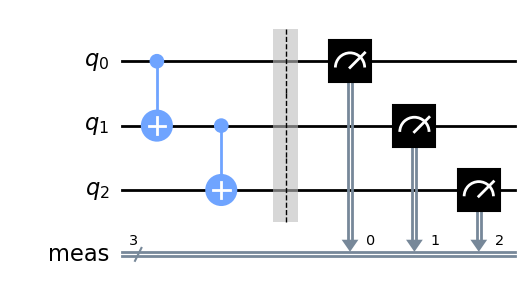

In [41]:
def simple_circuit():
    """Creates a simple quantum circuit with 3 qubits."""
    qc = QuantumCircuit(3)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.measure_all()
    return qc

simple_circuit().draw("mpl")

In [28]:
np.array([[1, 1, 1], [1, 1, 1], [0, 1, 1]])

array([[1, 1, 1],
       [1, 1, 1],
       [0, 1, 1]])

In [37]:
np.allclose(gidnet.biadjacency_matrix, np.array([[1, 1, 1], [1, 1, 1], [0, 1, 1]]))

True

In [36]:
np.allclose(gidnet.candidate_matrix, (np.ones((3, 3), dtype=int) - np.array([[1, 1, 1], [1, 1, 1], [0, 1, 1]])).T)

False

In [58]:
qc = simple_circuit()
gidnet = GidNET(qc)
# gidnet.compile_to_dynamic_circuit(iterations=10)

In [26]:
gidnet.qubit_reuse_sequences

[[0, 2], [1]]

In [59]:
gidnet.compute_intial_biadjacency_and_candidate_matrix()
# gidnet.biadjacency_matrix

(array([[1, 1, 1],
        [1, 1, 1],
        [0, 1, 1]]),
 array([[0, 0, 1],
        [0, 0, 0],
        [0, 0, 0]]))

In [57]:
gidnet.b

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

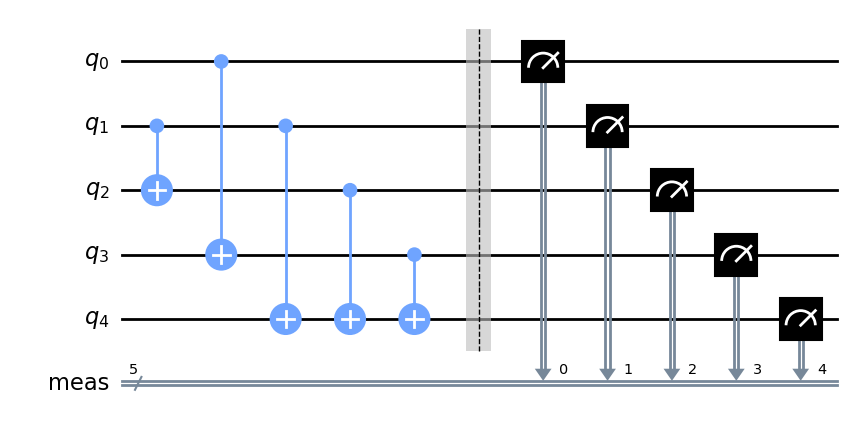

In [8]:
def complex_circuit():
    """Creates a more complex quantum circuit with 5 qubits."""
    qc = QuantumCircuit(5)
    qc.cx(1, 2)
    qc.cx(0, 3)
    qc.cx(1, 4)
    qc.cx(2, 4)
    qc.cx(3, 4)
    qc.measure_all()
    return qc

complex_circuit().draw("mpl")

In [ ]:
[[1, 0], [2, 3], [4]]
[[1, 3], [2, 0], [4]]

### F-test and R-squared values

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Define your circuit sizes and corresponding theoretical and experimental values
circuit_size = np.array(df["Circuit Sizes"])
theoretical_values = np.array(model_gidnet(df["Circuit Sizes"], *popt_gidnet))
experimental_values = np.array(df["GidNET Average Runtime"])

# Fit the polynomial regression
degree=3
poly_features = PolynomialFeatures(degree)
X_poly = poly_features.fit_transform(circuit_size.reshape(-1, 1))
model = LinearRegression().fit(X_poly, experimental_values)
predicted_values = model.predict(X_poly)

# Calculate R-squared value
r_squared = r2_score(experimental_values, predicted_values)

# Compute the F-statistic
n = len(circuit_size)
k = degree + 1  # Degree of polynomial + 1 (for the intercept)
f_statistic = (r_squared / (1 - r_squared)) * ((n - k - 1) / k)

print("R-squared value:", r_squared)
print("F-statistic:", f_statistic)


In [ ]:
n=4
R-squared value: 0.9989617396275322
F-statistic: 2116.728987697878

In [ ]:
# Define your circuit sizes and corresponding theoretical and experimental values
circuit_size = np.array(df["Circuit Sizes"])
theoretical_values = np.array(model_qnet(df["Circuit Sizes"], *popt_qnet))
experimental_values = np.array(df["QNET Average Runtime"])


# Fit the polynomial regression
degree=5
poly_features = PolynomialFeatures(degree)
X_poly = poly_features.fit_transform(circuit_size.reshape(-1, 1))
model = LinearRegression().fit(X_poly, experimental_values)
predicted_values = model.predict(X_poly)

# Calculate R-squared value
r_squared = r2_score(experimental_values, predicted_values)

# Compute the F-statistic
n = len(circuit_size)
k = degree + 1  # Degree of polynomial + 1 (for the intercept)
f_statistic = (r_squared / (1 - r_squared)) * ((n - k - 1) / k)

print("R-squared value:", r_squared)
print("F-statistic:", f_statistic)

### GidNET Speedup

#### Geometric mean speedup

In [ ]:
import pandas as pd
import numpy as np

# Load the data
data_path = 'data_cutqc_supremacy_cct/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv'
data = pd.read_csv(data_path)

# Calculate the individual speedups
speedup_vs_qnet = data['QNET Average Runtime'] / data['GidNET Average Runtime']
# speedup_vs_qiskit = data['Qiskit Average Runtime'] / data['GidNET Average Runtime']
speedup_vs_qiskit = data['GidNET Average Runtime'] / data['Qiskit Average Runtime']

# Calculate the geometric mean of the speedups
geo_mean_speedup_vs_qnet = np.prod(speedup_vs_qnet) ** (1 / len(speedup_vs_qnet))
geo_mean_speedup_vs_qiskit = np.prod(speedup_vs_qiskit) ** (1 / len(speedup_vs_qiskit))

# Calculate the percentage execution time reduction
percent_reduction_vs_qnet = 100 * (1 - 1 / geo_mean_speedup_vs_qnet)
percent_reduction_vs_qiskit = 100 * (1 - 1 / geo_mean_speedup_vs_qiskit)

# Create a summary DataFrame
performance_improvement_geo_mean = pd.DataFrame({
    'Geometric Mean Speedup vs QNET (X)': [geo_mean_speedup_vs_qnet],
    'Percentage Execution Time Reduction vs QNET (%)': [percent_reduction_vs_qnet],
    'Geometric Mean Speedup vs Qiskit (X)': [geo_mean_speedup_vs_qiskit],
    'Percentage Execution Time Reduction vs Qiskit (%)': [percent_reduction_vs_qiskit]
})

performance_improvement_geo_mean


In [ ]:
# speedup_vs_qnet

In [ ]:
import pandas as pd
import numpy as np

# Load the data
data_path = 'data_cutqc_supremacy_cct/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv'
data = pd.read_csv(data_path)

# Calculate the individual speedups for width
speedup_width_vs_qnet = data['QNET Width'] / data['GidNET Width']
speedup_width_vs_qiskit = data['Qiskit Width'] / data['GidNET Width']

# Calculate the geometric mean of the speedups for width
geo_mean_speedup_width_vs_qnet = np.prod(speedup_width_vs_qnet) ** (1 / len(speedup_width_vs_qnet))
geo_mean_speedup_width_vs_qiskit = np.prod(speedup_width_vs_qiskit) ** (1 / len(speedup_width_vs_qiskit))

# Calculate the percentage width reduction
percent_width_reduction_vs_qnet = 100 * (1 - 1 / geo_mean_speedup_width_vs_qnet)
percent_width_reduction_vs_qiskit = 100 * (1 - 1 / geo_mean_speedup_width_vs_qiskit)

# Create a summary DataFrame
width_improvement_geo_mean = pd.DataFrame({
    'Geometric Mean Speedup Width vs QNET': [geo_mean_speedup_width_vs_qnet],
    'Geometric Mean Speedup Width vs Qiskit': [geo_mean_speedup_width_vs_qiskit],
    'Percentage Width Reduction vs QNET (%)': [percent_width_reduction_vs_qnet],
    'Percentage Width Reduction vs Qiskit (%)': [percent_width_reduction_vs_qiskit]
})

width_improvement_geo_mean


In [ ]:
# speedup_width_vs_qnet

#### Arithmetic mean speedup

In [ ]:
# Load the data
# Load the data
data_path = 'data_cutqc_supremacy_cct/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv'
data = pd.read_csv(data_path)

# Calculate the percentage reduction in average runtime
runtime_reduction_vs_qnet = (1 - data['GidNET Average Runtime'] / data['QNET Average Runtime']) * 100
runtime_reduction_vs_qiskit = (1 - data['Qiskit Average Runtime'] / data['GidNET Average Runtime']) * 100

# Calculate the percentage reduction in final circuit width
width_reduction_vs_qnet = (1 - data['GidNET Width'] / data['QNET Width']) * 100
width_reduction_vs_qiskit = (1 - data['GidNET Width'] / data['Qiskit Width']) * 100

# Create a summary DataFrame
performance_improvement = pd.DataFrame({
    'Circuit Sizes': data['Circuit Sizes'],
    'Runtime Reduction vs QNET (%)': runtime_reduction_vs_qnet,
    'Runtime Reduction vs Qiskit (%)': runtime_reduction_vs_qiskit,
    'Width Reduction vs QNET (%)': width_reduction_vs_qnet,
    'Width Reduction vs Qiskit (%)': width_reduction_vs_qiskit
})

performance_improvement


In [ ]:
performance_improvement["Runtime Reduction vs QNET (%)"].mean()

In [ ]:
performance_improvement["Runtime Reduction vs Qiskit (%)"].mean()

In [ ]:
# Load the data
# Load the data
data_path = 'data_cutqc_supremacy_cct/combined_v02_width_and_runtime_cutqc_supremacy_cct_data.csv'
data = pd.read_csv(data_path)

# Calculate how many X faster
runtime_reduction_vs_qnet = (data['QNET Average Runtime'] / data['GidNET Average Runtime'])
runtime_reduction_vs_qiskit = (data['GidNET Average Runtime'] / data['Qiskit Average Runtime'])

# Calculate the percentage reduction in final circuit width
width_reduction_vs_qnet = (1 - data['GidNET Width'] / data['QNET Width']) * 100
width_reduction_vs_qiskit = (1 - data['GidNET Width'] / data['Qiskit Width']) * 100

# Create a summary DataFrame with corrected values
performance_improvement_corrected = pd.DataFrame({
    'Circuit Sizes': data['Circuit Sizes'],
    'Runtime Reduction vs QNET (x)': runtime_reduction_vs_qnet,
    'Runtime Reduction vs Qiskit (x)': runtime_reduction_vs_qiskit,
    'Width Reduction vs QNET (%)': width_reduction_vs_qnet,
    'Width Reduction vs Qiskit (%)': width_reduction_vs_qiskit
})

performance_improvement_corrected


In [ ]:
performance_improvement_corrected["Runtime Reduction vs QNET (x)"].mean()

In [ ]:
performance_improvement_corrected["Runtime Reduction vs Qiskit (x)"].mean()

In [ ]:
performance_improvement_corrected["Width Reduction vs QNET (%)"].mean()

In [ ]:
performance_improvement_corrected["Width Reduction vs Qiskit (%)"].mean()

In [ ]:
# Calculate the average improvement of GidNET over QNET and Qiskit in terms of runtime
gidnet_faster_than_qnet = (data['QNET Average Runtime'] - data['GidNET Average Runtime']) / data['QNET Average Runtime']
# gidnet_faster_than_qiskit = (data['Qiskit Average Runtime'] - data['GidNET Average Runtime']) / data['Qiskit Average Runtime']
# Calculate how much faster Qiskit is compared to GidNET in percentage terms
qiskit_faster_than_gidnet = (data['GidNET Average Runtime'] - data['Qiskit Average Runtime']) / data['GidNET Average Runtime']



average_improvement_qnet = gidnet_faster_than_qnet.mean() * 100
# average_improvement_qiskit = gidnet_faster_than_qiskit.mean() * 100
average_faster_qiskit = qiskit_faster_than_gidnet.mean() * 100

average_improvement_qnet, average_faster_qiskit


In [ ]:
# Re-load the data from the newly provided file path and calculate the circuit width differences
# file_path_new = '/mnt/data/combined_width_and_runtime_cutqc_supremacy_data.csv'
# data_new = pd.read_csv(file_path_new)

# Calculate the percentage improvements in circuit width for GidNET compared to QNET and Qiskit
gidnet_better_than_qnet_width_new = ((data['QNET Width'] - data['GidNET Width']) / data['QNET Width']) 
gidnet_better_than_qiskit_width_new = ((data['Qiskit Width'] - data['GidNET Width']) / data['Qiskit Width']) 

average_better_width_qnet_new = gidnet_better_than_qnet_width_new.mean() * 100
average_better_width_qiskit_new = gidnet_better_than_qiskit_width_new.mean() * 100

average_better_width_qnet_new, average_better_width_qiskit_new


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Define your circuit sizes and corresponding theoretical and experimental values
circuit_size = np.array(df["Circuit Sizes"])
theoretical_values = np.array(model_gidnet(df["Circuit Sizes"], *popt_gidnet))
experimental_values = np.array(df["GidNET Average Runtime"])

# Fit the polynomial regression
degree=3
poly_features = PolynomialFeatures(degree)
X_poly = poly_features.fit_transform(circuit_size.reshape(-1, 1))
model = LinearRegression().fit(X_poly, experimental_values)
predicted_values = model.predict(X_poly)

# Calculate R-squared value
r_squared = r2_score(experimental_values, predicted_values)

# Compute the F-statistic
n = len(circuit_size)
k = degree + 1  # Degree of polynomial + 1 (for the intercept)
f_statistic = (r_squared / (1 - r_squared)) * ((n - k - 1) / k)

print("R-squared value:", r_squared)
print("F-statistic:", f_statistic)
